# Libraries

In [1]:
import os

# Print out the location/directory of this jupyter notebook file
notebook_path = os.getcwd()
print(notebook_path)

/workspace/Brian2_projects


In [2]:
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 143.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 153.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 45.8 MB/s eta 0:00:00


In [3]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 175.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 180.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 181.8 MB/s eta 0:00:00


In [4]:
from brian2 import *

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    plt.figure(figsize=(10, 4))

    # the left-hand side plot
    plt.subplot(121)
    plt.plot(zeros(Ns), arange(Ns), 'ok', ms=10) # 'ok': circle marker - black; ms: marker size
    plt.plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plt.plot([0, 1], [i, j], '-k') # '-k': solid line - black
    plt.xticks([0, 1], ['Source', 'Target'])
    plt.ylabel('Neuron index')
    plt.xlim(-0.1, 1.1)
    #print()
    plt.ylim(-1, max([Ns,Nt]))
    #plt.ylim(-1, Ns)

    # The right-hand side plot
    plt.subplot(122)
    plt.plot(S.i, S.j, 'ok')
    plt.xlim(-1, Ns)
    plt.ylim(-1, Nt)
    plt.xlabel('Source neuron index')
    plt.ylabel('Target neuron index')

    # save
    plt.savefig('NetworkConnections')

# References

[0] Understanding the homeostasis: Watt, A. J., & Desai, N. S. (2010). Homeostatic plasticity and STDP: keeping a neuron’s cool in a fluctuating world. Frontiers in Synaptic Neuroscience, 2. https://doi.org/10.3389/fnsyn.2010.00005

[1] Homeostasis code: https://brian2.readthedocs.io/en/latest/examples/frompapers.Clopath_et_al_2010_homeostasis.html 

[2] https://brian2.readthedocs.io/en/latest/examples/frompapers.Vogels_et_al_2011.html

[3] Homeostasis integrated in STDP biased towards LTD: Song S, Abbott LF. Cortical development and remapping through spike timing-dependent plasticity. Neuron. 2001 Oct 25;32(2):339-50. doi: 10.1016/s0896-6273(01)00451-2. PMID: 11684002.


# Experiment

## from [1], with comparison to my modification

In [ ]:
start_scope()
################################################################################
# PLASTICITY MODEL
################################################################################

#### Plasticity Parameters

V_rest = -70.*mV        # resting potential
V_thresh = -55.*mV      # spiking threshold
Theta_low = V_rest      # depolarization threshold for plasticity
x_reset = 1.            # spike trace reset value
taux = 15.*ms           # spike trace time constant
A_LTD = 1.5e-4          # depression amplitude
A_LTP = 1.5e-2          # potentiation amplitude
tau_lowpass1 = 40*ms    # timeconstant for low-pass filtered voltage
tau_lowpass2 = 30*ms    # timeconstant for low-pass filtered voltage
tau_homeo = 1000*ms     # homeostatic timeconstant
v_target = 12*mV**2     # target depolarisation

#### Plasticity Equations

# equations executed at every timestepC
Syn_model =   ('''
            w_ampa:1                # synaptic weight (ampa synapse)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq = ('''
            g_ampa_post += w_ampa*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/mV - Theta_low/mV)*int(v_lowpass1_post/mV - Theta_low/mV > 0)  # synaptic depression
            w_ampa = clip(w_ampa-w_minus, 0, w_max)                                                           # hard bounds
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq = ('''
            v_lowpass1 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1*mV                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_pre*(v_lowpass2_post/mV - Theta_low/mV)*int(v_lowpass2_post/mV - Theta_low/mV > 0)  # synaptic potentiation
            w_ampa = clip(w_ampa+w_plus, 0, w_max)                                                                     # hard bounds
            ''' )

# My equations executed at every timestepC
Syn_model_m =   ('''
            w_ampa:1                # synaptic weight (ampa synapse)
            dx_trace_prespike/dt = -x_trace_prespike/taux :1  (event-driven)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq_m = ('''
            g_ampa_post += w_ampa*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/mV - Theta_low/mV)*int(v_lowpass1_post/mV - Theta_low/mV > 0)  # synaptic depression
            w_ampa = clip(w_ampa-w_minus, 0, w_max)                                                           # hard bounds
            x_trace_prespike+=x_reset/(taux/ms)
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq_m = ('''
            v_lowpass1 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1*mV                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_prespike*(v_lowpass2_post/mV - Theta_low/mV)*int(v_lowpass2_post/mV - Theta_low/mV > 0)  # synaptic potentiation
            w_ampa = clip(w_ampa+w_plus, 0, w_max)                                                                     # hard bounds
            ''' )
################################################################################
# I&F Parameters and equations
################################################################################

#### Neuron parameters

gleak = 30.*nS                  # leak conductance
C = 300.*pF                     # membrane capacitance
tau_AMPA = 2.*ms                # AMPA synaptic timeconstant
E_AMPA = 0.*mV                  # reversal potential AMPA

ampa_max_cond = 5.e-8*siemens  # Ampa maximal conductance
w_max = 1.                      # maximal ampa weight

#### Neuron Equations

# We connect 10 presynaptic neurons to 1 downstream neuron

# downstream neuron
eqs_neurons = '''
dv/dt = (gleak*(V_rest-v) + I_ext + I_syn)/C: volt      # voltage
dv_lowpass1/dt = (v-v_lowpass1)/tau_lowpass1 : volt     # low-pass filter of the voltage
dv_lowpass2/dt = (v-v_lowpass2)/tau_lowpass2 : volt     # low-pass filter of the voltage
dv_homeo/dt = (v-V_rest-v_homeo)/tau_homeo : volt       # low-pass filter of the voltage
I_ext : amp                                             # external current
I_syn = g_ampa*(E_AMPA-v): amp                          # synaptic current
dg_ampa/dt = -g_ampa/tau_AMPA : siemens                 # synaptic conductance
dx_trace/dt = -x_trace/taux :1                          # spike trace
'''

# input neurons
eqs_inputs = '''
dv/dt = gleak*(V_rest-v)/C: volt                        # voltage
dx_trace/dt = -x_trace/taux :1                          # spike trace
rates : Hz                                              # input rates
selected_index : integer (shared)                       # active neuron
'''

################################################################################
# Simulation
################################################################################

#### Parameters

defaultclock.dt = 500.*us                        # timestep
Nr_neurons = 1                                   # Number of downstream neurons
Nr_inputs = 5                                    # Number of input neurons
input_rate = 35*Hz                               # Rates
init_weight = 0.5                                # initial synaptic weight
final_t = 20.*second                             # end of simulation
input_time = 100.*ms                             # duration of an input

#### Create neuron objects

Nrn_downstream = NeuronGroup(Nr_neurons*2, eqs_neurons, threshold='v>V_thresh',
                             reset='v=V_rest;x_trace+=x_reset/(taux/ms)',
                             method='euler')
Nrn_downstream_o = Nrn_downstream[:Nr_neurons]
Nrn_downstream_m = Nrn_downstream[Nr_neurons:]


Nrns_input = NeuronGroup(Nr_inputs, eqs_inputs, threshold='rand()<rates*dt',
                         reset='v=V_rest;x_trace+=x_reset/(taux/ms)',
                         method='exact')

#### create Synapses

Syn = Synapses(Nrns_input, Nrn_downstream_o,
               model=Syn_model,
               on_pre=Pre_eq,
               on_post=Post_eq
               )

Syn.connect(i=numpy.arange(Nr_inputs), j=0)

Syn_m = Synapses(Nrns_input, Nrn_downstream_m,
               model=Syn_model_m,
               on_pre=Pre_eq_m,
               on_post=Post_eq_m
               )

Syn_m.connect(i=numpy.arange(Nr_inputs), j=0)

#### Monitors and storage
W_evolution = StateMonitor(Syn, 'w_ampa', record=True)
W_evolution_m = StateMonitor(Syn_m, 'w_ampa', record=True)

#### Run

# Initial values
Nrn_downstream.v = V_rest
Nrn_downstream.v_lowpass1 = V_rest
Nrn_downstream.v_lowpass2 = V_rest
Nrn_downstream.v_homeo = 0
Nrn_downstream.I_ext = 0.*amp
Nrn_downstream.x_trace = 0.
Nrns_input.v = V_rest
Nrns_input.x_trace = 0.
Syn.w_ampa = init_weight

Syn_m.w_ampa = init_weight

# Switch on a different input every 100ms
Nrns_input.run_regularly('''
                         selected_index = int(floor(rand()*Nr_inputs))
                         rates = input_rate * int(selected_index == i)  # All rates are zero except for the selected neuron
                         ''', dt=input_time)
run(final_t, report='text')

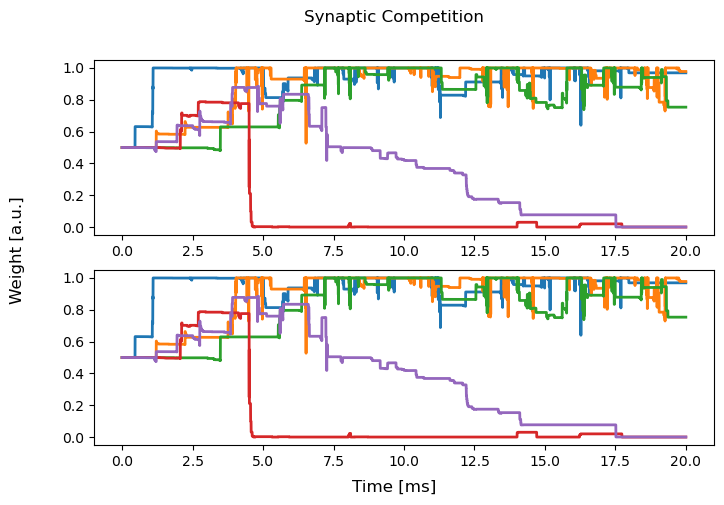

In [8]:
################################################################################
# Plots
################################################################################


fig, axs = plt.subplots(2, figsize=(8, 5)) #sharex=True, sharey=True
fig.suptitle('Synaptic Competition')

for kk in range(Nr_inputs):
    axs[0].plot(W_evolution.t, W_evolution.w_ampa[kk], '-', linewidth=2)
    axs[1].plot(W_evolution_m.t, W_evolution_m.w_ampa[kk], '-', linewidth=2)


fig.supxlabel('Time [ms]', fontsize=12)
fig.supylabel('Weight [a.u.]', fontsize=12)

#subplots_adjust(bottom=0.2, left=0.15, right=0.95, top=0.85)
#title(stitle, fontsize=22)
show()

## case 3: same as case 2, but combine and compare different parameters of stdp, neuron 

### Network

In [71]:
#### Neuron without/with adaptive threshold

start_scope()
defaultclock.dt = 500.*us 

# Poisson input group
N_INP = 20
inp_rates = np.ones(N_INP)* 3 * Hz
pg_inp = PoissonGroup(N_INP, inp_rates, name = 'inp') 


# Excictory group with adaptive threshold

############
##SUB GROUP REF:
##G = NeuronGroup(10, '''dv/dt = -v/tau : volt
##                       tau : second''',
##                threshold='v > -50*mV',
##                reset='v = -70*mV')
# Create subgroups
##G1 = G[:5]
##G2 = G[5:]

# This will set the values in the main group, subgroups are just "views"
##G1.tau = 10*ms
##G2.tau = 20*ms
############


N_NEURONS = 4

v_rest = 0
v_thresh_e = 24e-3
v_inh_base = 0
v_exc_base = 70e-3
v_reset= 10e-3

tau_ge = 5*ms
tau_gi = 5*ms
tau_mem = 50*ms
tc_theta= 1e7 * ms #1e7 * ms # 10 * ms # 1e7 * ms 

tau_lowpass1 = 40*ms    # timeconstant for low-pass filtered voltage
tau_lowpass2 = 30*ms    # timeconstant for low-pass filtered voltage
tau_homeo = 1000*ms     # homeostatic timeconstant

# Gaussian distribution - Brian2 : randn()
# Uniformaly distribution - Brian2 : rand()
refrac_mu, refrac_sigma = 5, 5e-2 # mean and standard deviation
refractor_model = '(5 +  + refrac_sigma*randn())*ms' # 5*ms

eqs = '''
dv/dt = (v_rest-v + i_exc + i_inh)/tau_mem + sigma*xi*tau_mem**-0.5 : 1 (unless refractory)
i_exc = ge   * (v_exc_base -v)            : 1
i_inh = gi   * (v_inh_base - v)           : 1
dge/dt = -ge/ tau_ge                  : 1
dgi/dt = -gi/ tau_gi                  : 1
dtheta/dt = -theta / (tc_theta)         : 1
dtimer/dt = 0.1                           : second
sigma : 1

dv_lowpass1/dt = (v-v_lowpass1)/tau_lowpass1 : 1     # low-pass filter of the voltage
dv_lowpass2/dt = (v-v_lowpass2)/tau_lowpass2 : 1     # low-pass filter of the voltage
dv_homeo/dt = (v-v_rest-v_homeo)/tau_homeo : 1       # low-pass filter of the voltage
'''

# Excictory group with adaptive threshold
theta_plus_e = 0.05
theta_plus_e_mu, theta_plus_ec_sigma = 0, 0.05e-2 # mean and standard deviation

reset = '''
v = v_reset
theta += (theta_plus_e + (theta_plus_e_mu + theta_plus_ec_sigma*randn()))* 1e-3
timer = 0 * ms
'''

threshold_mu, threshold_sigma = 0, (v_thresh_e*1e-2)
# adpt, timer
threshold_adpt_timer = '(v>(theta + v_thresh_e + (threshold_mu + threshold_sigma*randn()))) and (timer>refrac_mu*ms)' # '(v>(theta + v_thresh_e)) and (timer>refractory)'
# adpt, no timer
threshold_adpt = 'v>(theta + v_thresh_e + (threshold_mu + threshold_sigma*randn()))'


ng_exc = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt_timer, 
    reset=reset, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc')
ng_exc.sigma = 1.2 * (v_thresh_e - v_reset)

# Excictory group without adaptive threshold
reset_no_adthr = '''
v = v_reset
'''
ng_exc_no_adthr = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt, 
    reset=reset_no_adthr, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc_no_adthr')
ng_exc_no_adthr.sigma = 1.2 * (v_thresh_e - v_reset)

# Excictory group with adaptive threshold, small nosie
ng_exc_sm_noise = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt_timer,
    reset=reset, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc_sm_noise')
ng_exc_sm_noise.sigma = 0.5 * (v_thresh_e - v_reset)

# Excictory group without adaptive threshold, volt_stdp (vstdp)
ng_exc_no_adthr_vstdp = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt, 
    reset=reset_no_adthr, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc_no_adthr_vstdp')
ng_exc_no_adthr_vstdp.sigma = 0.5 * (v_thresh_e - v_reset) # 0.5 * (v_thresh_e - v_reset)
ng_exc_no_adthr_vstdp.v_lowpass1 = v_rest
ng_exc_no_adthr_vstdp.v_lowpass2 = v_rest
ng_exc_no_adthr_vstdp.v_homeo = 0

# Excictory group adaptive threshold, volt_stdp (vstdp)
ng_exc_adthr_vstdp = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt, 
    reset=reset, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc_adthr_vstdp')
ng_exc_adthr_vstdp.sigma = 0.5 * (v_thresh_e - v_reset) # 0.5 * (v_thresh_e - v_reset)
ng_exc_adthr_vstdp.v_lowpass1 = v_rest
ng_exc_adthr_vstdp.v_lowpass2 = v_rest
ng_exc_adthr_vstdp.v_homeo = 0


# Inhibitory Group group
v_thresh_i =  10
v_reset_i = 0

inh_eqs = '''
    v   : 1
'''

ng_inh = NeuronGroup(
            N_NEURONS * 5 * 10, inh_eqs,
            threshold = 'v > v_thresh_i',
            #refractory = 2 * ms,
            reset = 'v = v_reset_i',
            method = 'exact',
            name = 'inh')
ng_inh.v = 0

ng_inh_adthr = ng_inh[:N_NEURONS*10]
ng_inh_no_adthr = ng_inh[N_NEURONS*10:N_NEURONS*20]
ng_inh_adthr_sm_noise = ng_inh[N_NEURONS*20:N_NEURONS*30]
ng_inh_no_adthr_vstdp = ng_inh[N_NEURONS*30:N_NEURONS*40]
ng_inh_adthr_vstdp = ng_inh[N_NEURONS*40:]


##### Synapse Definition

## From input layer to excitory layer with adaptive threshold
wmax = 2 #5 #2 #1
n_minus = 1 # 0.005 #0.0001 # depression learning rate
n_plus = 1 # 0.5 #0.01 # potentiation learning rate
taupre =  20 *ms # 20 * ms 
taupost =  20 * ms # 20 *ms
Apre = 0.02*wmax # 0.05 # 0.03 
Bff = 1.1 #1.05
Apost = -(Bff * Apre * taupre) / taupost

on_pre ='''
apre += Apre
w = clip(w+ n_minus*apost , 0, wmax)
ge_post += w
'''
on_post = '''
apost += Apost
w = clip(w+ n_plus*apre, 0, wmax)
'''

model = '''
w : 1
dapre/dt = -apre/taupre : 1 (clock-driven) 
dapost/dt = -apost/taupost : 1 (clock-driven)
'''

syns_inp_exc = Synapses(
        pg_inp, ng_exc,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear',
        name = 'inp_exc'
    )
syns_inp_exc.connect(True) # same as syns_inp_exc.connect()
#syns_inp_exc.delay = 'rand() * 10 * ms' 
# np.random.random(<output size>)
#numpy.random.seed(0) # CAUTION: using this random seed, 
                     # causing the Poisson process of BRAIN2 DOES NOT WORK anymore (no more randomness in the Poisson spike generation).
                     # Therefore, must comment out this ! before running any experiments   
#mu, sigma = 0.5, 0.1 # mean and standard deviation
#size_output = N_INP * N_NEURONS
#s = np.random.normal(mu, sigma,size_output)
#weights = s
weights = wmax/2 # 2.5 #1 # 0.5
syns_inp_exc.w = weights

## From input layer to excitory layer without adaptive threshold
syns_inp_exc_no_adthr = Synapses(
        pg_inp, ng_exc_no_adthr,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear',
        name = 'inp_exc_no_adthr'
    )
syns_inp_exc_no_adthr.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_no_adthr.w = weights

## From input layer to excitory layer with adaptive threshold, small nosie
syns_inp_exc_adthr_sm_noise = Synapses(
        pg_inp, ng_exc_sm_noise,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear',
        name = 'inp_exc_no_adthr_sm_nosie'
    )
syns_inp_exc_adthr_sm_noise.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_adthr_sm_noise.w = weights

## From input layer to excitory layer no adaptive threshold, volt-dependent stdp
taux = 15.*ms
ampa_max_cond = 1 #1 # 1
v_target = (12e-3)**2 # (should be relative to vhomeo)
A_LTD = 1.5e-5 * wmax # 1.5e-7 # 1.5e-4 # like the Apost in STDP synapse
A_LTP = 1e-3 * wmax #1.5e-2 # like the Apre in STDP synapse
Theta_low = v_rest
x_reset = 1

# My equations executed at every timestepC
Syn_model_m =   ('''
            w:1                # synaptic weight (ampa synapse)
            #x_trace_prespike:1
            dx_trace_prespike/dt = -x_trace_prespike/taux :1  (event-driven)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq_m = ('''
            ge_post += w*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/(1e-3) - Theta_low/(1e-3))*int(v_lowpass1_post/(1e-3) - Theta_low/(1e-3) > 0)  # synaptic depression
            w = clip(w - w_minus, 0, wmax)                                                           # hard bounds
            x_trace_prespike+=x_reset/(taux/ms)
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq_m = ('''
            v_lowpass1 += 10e-3                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10e-3                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1e-3                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_prespike*(v_lowpass2_post/(1e-3) - Theta_low/(1e-3))*int(v_lowpass2_post/(1e-3) - Theta_low/(1e-3) > 0)  # synaptic potentiation
            w = clip(w + w_plus, 0, wmax)                                                                     # hard bounds
            ''' )

syns_inp_exc_no_adthr_vstdp = Synapses(
        pg_inp, ng_exc_no_adthr_vstdp,
        model = Syn_model_m,
        on_pre = Pre_eq_m,
        on_post = Post_eq_m,
        method='linear',
        name = 'inp_exc_no_adthr_vstdp'
    )
syns_inp_exc_no_adthr_vstdp.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_no_adthr_vstdp.w = weights
syns_inp_exc_no_adthr_vstdp.x_trace_prespike = 0

## From input layer to excitory layer adaptive threshold, volt-dependent stdp
syns_inp_exc_adthr_vstdp = Synapses(
        pg_inp, ng_exc_adthr_vstdp,
        model = Syn_model_m,
        on_pre = Pre_eq_m,
        on_post = Post_eq_m,
        method='linear',
        name = 'inp_exc_adthr_vstdp'
    )
syns_inp_exc_adthr_vstdp.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_adthr_vstdp.w = weights
syns_inp_exc_adthr_vstdp.x_trace_prespike = 0

## from excitory layer to exct layer
syns_exc_exc_adthr_time_bnoise = Synapses(
        ng_exc, ng_exc,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_adthr_time_bnoise.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_adthr_time_bnoise.w = 0

syns_exc_exc_no_adthr = Synapses(
        ng_exc_no_adthr, ng_exc_no_adthr,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_no_adthr.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_no_adthr.w = 0

syns_exc_exc_adthr_time_snoise = Synapses(
        ng_exc_sm_noise, ng_exc_sm_noise,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_adthr_time_snoise.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_adthr_time_snoise.w = 0

syns_exc_exc_no_adthr_vstdp = Synapses(
        ng_exc_no_adthr_vstdp, ng_exc_no_adthr_vstdp,
        model = Syn_model_m, #change
        on_pre = Pre_eq_m, #change
        on_post = Post_eq_m, #change
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_no_adthr_vstdp.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_no_adthr_vstdp.w = 0

syns_exc_exc_adthr_vstdp = Synapses(
        ng_exc_adthr_vstdp, ng_exc_adthr_vstdp,
        model = Syn_model_m, #change
        on_pre = Pre_eq_m, #change
        on_post = Post_eq_m, #change
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_adthr_vstdp.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_adthr_vstdp.w = 0


## From excitory layer to inhibitory layer
W_EXC_INH = 17.0 # > v_thresh_i 
syns_exc_inh = Synapses(ng_exc, ng_inh_adthr,
                            on_pre = 'v_post += W_EXC_INH')
#syns_exc_inh.connect(j = 'i')
syns_exc_inh.connect(True)

syns_exc_inh_no_adthr = Synapses(ng_exc_no_adthr, ng_inh_no_adthr,
                            on_pre = 'v_post += W_EXC_INH')
#syns_exc_inh_no_adthr.connect(j = 'i')
syns_exc_inh_no_adthr.connect(True)

syns_exc_inh_adthr_sm_noise = Synapses(ng_exc_sm_noise, ng_inh_adthr_sm_noise,
                            on_pre = 'v_post += W_EXC_INH')
syns_exc_inh_adthr_sm_noise.connect(True)

syns_exc_inh_no_adthr_vstdp = Synapses(ng_exc_no_adthr_vstdp, ng_inh_no_adthr_vstdp,
                            on_pre = 'v_post += W_EXC_INH')
syns_exc_inh_no_adthr_vstdp.connect(True)

syns_exc_inh_adthr_vstdp = Synapses(ng_exc_adthr_vstdp, ng_inh_adthr_vstdp,
                            on_pre = 'v_post += W_EXC_INH')
syns_exc_inh_adthr_vstdp.connect(True)

## From inhibitory layer to excitory layer
W_INH_EXC = 0.01*wmax # 0.01*wmax (Good for few epochs but for much more epochs, still BAD ) # 0.5*wmax (BAD -> cause neuron domination) #0.05*wmax
syns_inh_exc = Synapses(ng_inh_adthr, ng_exc,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc.connect(condition='i!=j')

syns_inh_exc_no_adthr = Synapses(ng_inh_no_adthr, ng_exc_no_adthr,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_no_adthr.connect(condition='i!=j')

syns_inh_exc_adthr_sm_noise = Synapses(ng_inh_adthr_sm_noise, ng_exc_sm_noise,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_adthr_sm_noise.connect(condition='i!=j')

syns_inh_exc_no_adthr_vstdp = Synapses(ng_inh_no_adthr_vstdp, ng_exc_no_adthr_vstdp,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_no_adthr_vstdp.connect(condition='i!=j')

syns_inh_exc_adthr_vstdp = Synapses(ng_inh_adthr_vstdp, ng_exc_adthr_vstdp,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_adthr_vstdp.connect(condition='i!=j')

WARNING    'i' is an internal variable of group 'synapses_40', but also exists in the run namespace with the value 199. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_41', but also exists in the run namespace with the value 199. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_42', but also exists in the run namespace with the value 199. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_43', but also exists in the run namespace with the value 199. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_44', but also exists in the run namespace with the value 199. The internal variable will be us

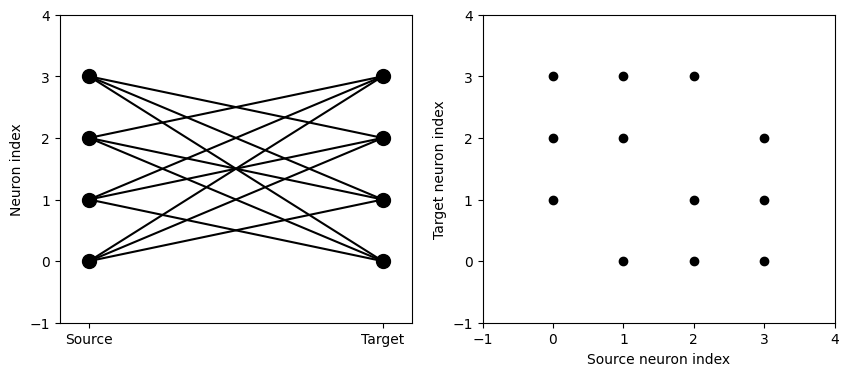

In [49]:
visualise_connectivity(syns_exc_exc_adthr_vstdp)

### Recording + net setup

In [72]:
# Recording 
syns_inp_exc_mon = StateMonitor(syns_inp_exc,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_inp_exc_no_adthr_mon = StateMonitor(syns_inp_exc_no_adthr,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_inp_exc_adthr_sm_noise_mon = StateMonitor(syns_inp_exc_adthr_sm_noise,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_inp_exc_no_adthr_vstdp_mon = StateMonitor(syns_inp_exc_no_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)
syns_inp_exc_adthr_vstdp_mon = StateMonitor(syns_inp_exc_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)

syns_exc_exc_adthr_time_bnoise_mon = StateMonitor(syns_exc_exc_adthr_time_bnoise,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_exc_exc_no_adthr_mon = StateMonitor(syns_exc_exc_no_adthr,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_exc_exc_adthr_time_snoise_mon = StateMonitor(syns_exc_exc_adthr_time_snoise,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_exc_exc_no_adthr_vstdp_mon = StateMonitor(syns_exc_exc_no_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)
syns_exc_exc_adthr_vstdp_mon = StateMonitor(syns_exc_exc_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)


#ng_exc_mon = StateMonitor(ng_exc,  ['v', 'theta', 'ge', 'gi'], record=True)
#ng_exc_no_adthr_mon = StateMonitor(ng_exc_no_adthr,  ['v', 'theta', 'ge', 'gi'], record=True)
#ng_exc_sm_noise_mon = StateMonitor(ng_exc_sm_noise,  ['v', 'theta', 'ge', 'gi'], record=True)
#ng_exc_no_adthr_vstdp_mon = StateMonitor(ng_exc_no_adthr_vstdp,  ['v', 'theta', 'ge', 'gi', 'v_lowpass1', 'v_lowpass2', 'v_homeo'], record=True)
#ng_exc_adthr_vstdp_mon = StateMonitor(ng_exc_adthr_vstdp,  ['v', 'theta', 'ge', 'gi', 'v_lowpass1', 'v_lowpass2', 'v_homeo'], record=True)

ng_exc_spikemon = SpikeMonitor(ng_exc)
ng_exc_no_adthr_spikemon = SpikeMonitor(ng_exc_no_adthr)
ng_exc_sm_noise_spikemon = SpikeMonitor(ng_exc_sm_noise)
ng_exc_no_adthr_vstdp_spikemon = SpikeMonitor(ng_exc_no_adthr_vstdp)
ng_exc_adthr_vstdp_spikemon = SpikeMonitor(ng_exc_adthr_vstdp)

ng_inp_spikemon = SpikeMonitor(pg_inp)

net = Network([pg_inp, ng_exc, ng_exc_no_adthr, ng_exc_sm_noise, ng_exc_no_adthr_vstdp, ng_exc_adthr_vstdp,
               ng_inh, #ng_inh_adthr, ng_inh_no_adthr, #pg_noise,
               syns_inp_exc, syns_exc_inh, syns_inh_exc, syns_exc_exc_adthr_time_bnoise,
               syns_inp_exc_no_adthr, syns_exc_inh_no_adthr, syns_inh_exc_no_adthr, syns_exc_exc_no_adthr,
               syns_inp_exc_adthr_sm_noise, syns_exc_inh_adthr_sm_noise, syns_inh_exc_adthr_sm_noise, syns_exc_exc_adthr_time_snoise,
               syns_inp_exc_no_adthr_vstdp, syns_exc_inh_no_adthr_vstdp, syns_inh_exc_no_adthr_vstdp, syns_exc_exc_no_adthr_vstdp,
               syns_inp_exc_adthr_vstdp, syns_exc_inh_adthr_vstdp, syns_inh_exc_adthr_vstdp, syns_exc_exc_adthr_vstdp,
               syns_inp_exc_mon, syns_exc_exc_adthr_time_bnoise_mon, # ng_exc_mon, 
               syns_inp_exc_no_adthr_mon, syns_exc_exc_no_adthr_mon, # ng_exc_no_adthr_mon,
               syns_inp_exc_adthr_sm_noise_mon, syns_exc_exc_adthr_time_snoise_mon, # ng_exc_sm_noise_mon,
               syns_inp_exc_no_adthr_vstdp_mon, syns_exc_exc_no_adthr_vstdp_mon, # ng_exc_no_adthr_vstdp_mon,
               syns_inp_exc_adthr_vstdp_mon, syns_exc_exc_adthr_vstdp_mon, # ng_exc_adthr_vstdp_mon,
               ng_exc_spikemon, ng_exc_no_adthr_spikemon, ng_exc_sm_noise_spikemon, ng_exc_no_adthr_vstdp_spikemon, ng_exc_adthr_vstdp_spikemon,
               ng_inp_spikemon])

net.run(0*second)

### Run

In [73]:
rest_duration = 100 * ms # 50 * ms # 0 * ms
rest_freq = 0.5 # [Hz]
train_duration = 200 * ms # 100 * ms #  500 * ms



#inp_rates_0 = [6, 2, 2 , 2, 2, 2, 2, 2, 2 , 2,
#                2, 2, 2 , 2, 2, 2, 2, 2, 2 , 2 ] * Hz 

inp_rates_0 = [6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5 ] * Hz 

#inp_rates_0 = [20, 10, 9 , 8, 7, 6, 5, 4, 3, 2 ,
#                1, 0, 0 , 0, 0, 0, 0, 0, 0 , 0 ] * Hz 


inp_rates_1 = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 6 ] * Hz 

#inp_rates_1 = [2, 2, 2 , 2, 2, 2, 2, 2, 2 , 2,
#                2, 2, 2 , 2, 2, 2, 2, 2, 2 , 6 ] * Hz

#inp_rates_1 = [0, 0, 0 , 0, 0, 0, 0, 0, 0 , 1,
#                 2, 3, 4, 5 , 6, 7, 8, 9, 10 , 20 ] * Hz


inp_rates_2 = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 7, 0.5 , 0.5 ] * Hz 

inp_rates_3 = [0.5, 0.5, 7, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5 ] * Hz 

In [74]:
timing = 0*ms

In [57]:
epoch = 200
for i in range(epoch):
    print(f"step: {i+1}")

    # Train
    net['inp'].rates = inp_rates_0
    net.run(train_duration)
    timing += train_duration

    #rest
    net['inp'].rates = np.ones(N_INP)* rest_freq * Hz
    net.run(rest_duration)
    timing += rest_duration

    # Train
    net['inp'].rates = inp_rates_1
    net.run(train_duration)
    timing += train_duration

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_duration)
    timing += rest_duration

    # Train
    net['inp'].rates = inp_rates_2
    net.run(train_duration)
    timing += train_duration

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_duration)
    timing += rest_duration

    # Train
    net['inp'].rates = inp_rates_3
    net.run(train_duration)
    timing += train_duration

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_duration)
    timing += rest_duration

print("Done")

step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 110
step: 11

In [18]:
net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
net.run(10*rest_duration)

In [422]:
net['inp'].rates = inp_rates_0
net.run(500*ms)

#rest
net['inp'].rates = np.ones(N_INP)* Hz
net.run(5*second)

In [434]:
net['inp'].rates = inp_rates_1
net.run(500*ms)

#rest
net['inp'].rates = np.ones(N_INP) * Hz
net.run(5*second)

### Plot

In [58]:
print(timing/ms)

239999.99999999348


In [72]:
print(shape(ng_exc_spikemon.i), shape(ng_exc_no_adthr_spikemon.i))

(150,) (188,)


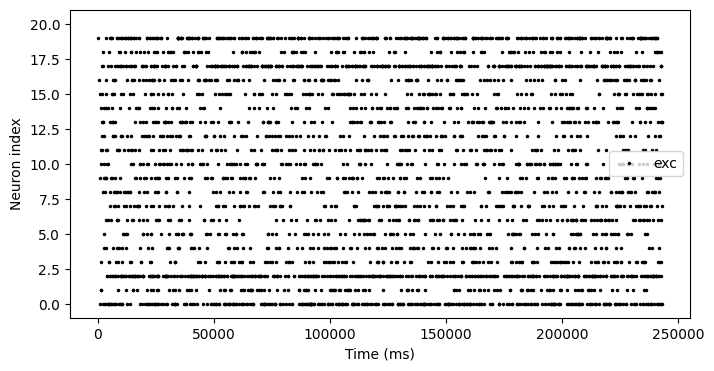

In [25]:
start = 0

plt.figure(figsize=(8, 4)) #sharex=True, sharey=True,
neuron_index_num = N_INP # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

plt.plot(ng_inp_spikemon.t[start:]/ms, ng_inp_spikemon.i[start:], '.k', ms=3, label ='exc')
plt.ylim(-1, neuron_index_num+1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()


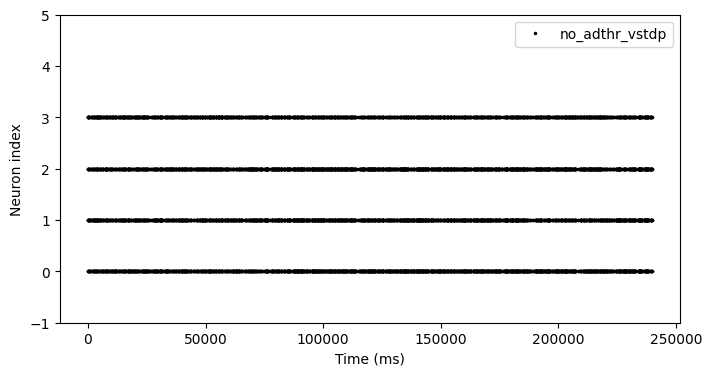

In [59]:
start = 0

plt.figure(figsize=(8, 4)) #sharex=True, sharey=True,
neuron_index_num = N_NEURONS # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

plt.plot(ng_exc_no_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_no_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='no_adthr_vstdp')
plt.ylim(-1, neuron_index_num+1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()

Text(0.02, 0.5, 'Neuron index')

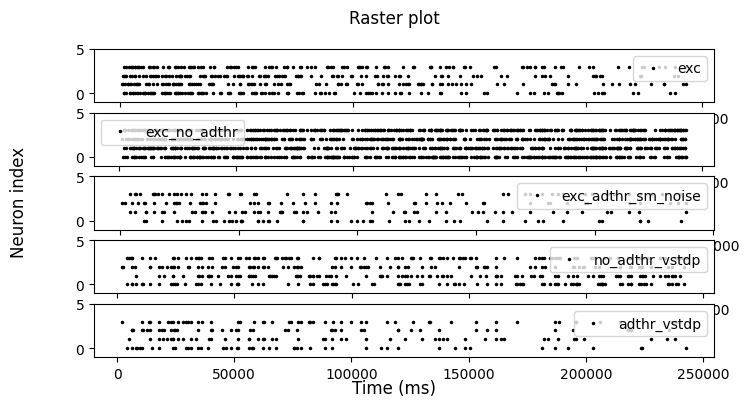

In [26]:
## Referece:
## [1] https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
## [2] https://stackoverflow.com/questions/15858192/how-to-set-xlim-and-ylim-for-a-subplot

start = 0

fig, axs = plt.subplots(5,  figsize=(8, 4)) #sharex=True, sharey=True,
fig.suptitle('Raster plot')
#plot(ng_input_spikemon.t/ms, ng_input_spikemon.i, '.r', ms=3, label = 'inp')
neuron_index_num = N_NEURONS # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

axs[0].plot(ng_exc_spikemon.t[start:]/ms, ng_exc_spikemon.i[start:], '.k', ms=3, label ='exc')
axs[0].set_ylim(-1, neuron_index_num+1)
axs[0].legend()

axs[1].plot(ng_exc_no_adthr_spikemon.t[start:]/ms, ng_exc_no_adthr_spikemon.i[start:], '.k', ms=3, label ='exc_no_adthr')
axs[1].set_ylim(-1, neuron_index_num+1)
axs[1].legend()

axs[2].plot(ng_exc_sm_noise_spikemon.t[start:]/ms, ng_exc_sm_noise_spikemon.i[start:], '.k', ms=3, label ='exc_adthr_sm_noise')
axs[2].set_ylim(-1, neuron_index_num+1)
axs[2].legend()

axs[3].plot(ng_exc_no_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_no_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='no_adthr_vstdp')
axs[3].set_ylim(-1, neuron_index_num+1)
axs[3].legend()

axs[4].plot(ng_exc_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='adthr_vstdp')
axs[4].set_ylim(-1, neuron_index_num+1)
axs[4].legend()

fig.supxlabel('Time (ms)')
fig.supylabel('Neuron index')

#legend()

[[ 9.90913176 10.         10.          9.99999997]
 [ 8.9261103   8.47235982  5.5291174   7.99450253]
 [ 9.98173928  9.9587922   9.95745138  9.93378622]
 [ 7.47707061  6.66381669  8.11971531  9.15349828]
 [ 6.31122232  6.92694246  7.97983373  7.34303558]
 [10.          7.46551519 10.          9.09799534]
 [ 9.09380479  7.111781    9.07815615  8.0118699 ]
 [ 7.32804812  9.71893033  8.34295274  9.48699667]
 [ 4.95893468  6.67738445  6.91925493  6.76561552]
 [ 6.62978242  6.36413706  6.73047844  8.62181328]
 [ 8.50866157  7.82797516  7.9571871   7.45567885]
 [ 6.84073386  8.09241446  6.91794587  6.85245869]
 [ 9.39086636  8.43989795  8.18340324  7.406933  ]
 [ 7.66257542  8.40099033  7.81661072  7.51400335]
 [ 7.52867262  5.11192898  5.51277322  6.50852693]
 [ 5.78853175  5.00376892  6.74996928  7.04148948]
 [ 8.2002211   6.59010669  9.00622692  7.92221483]
 [ 9.86945502  9.96259768 10.         10.        ]
 [ 7.11260898  7.26791125  5.65704829  7.81324591]
 [ 9.98596789  9.95134639 10.  

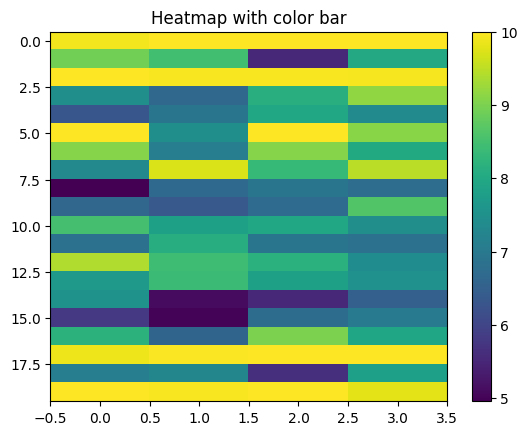

In [60]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc = np.full((len(pg_inp), len(ng_exc)), np.nan)
# Insert the values from the Synapses object
W_inp_exc[syns_inp_exc_mon.i[:,-1], syns_inp_exc_mon.j[:,-1]] = syns_inp_exc_mon.w[:, -1]
#W = syns_inp_exc_mon.w[:, 200000-1]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc)

[[           nan 1.91213783e-01 1.20959821e-08 2.28115341e-01]
 [9.78893018e+00            nan 9.99999956e+00 1.00000000e+01]
 [9.99999999e+00 3.99033238e-07            nan 9.99999998e+00]
 [9.74789179e+00 7.60281127e-34 2.14106995e-08            nan]]


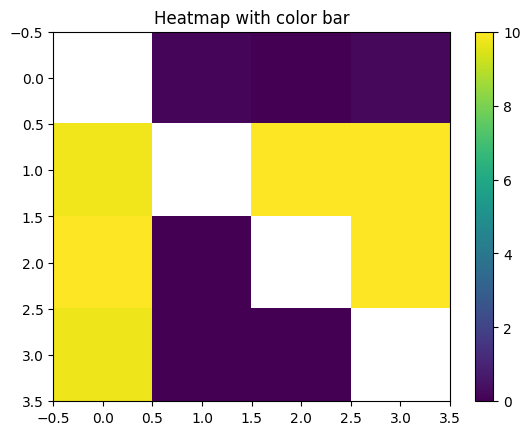

In [61]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc = np.full((len(ng_exc), len(ng_exc)), np.nan)
# Insert the values from the Synapses object
W_exc_exc[syns_exc_exc_adthr_time_bnoise_mon.i[:,-1], syns_exc_exc_adthr_time_bnoise_mon.j[:,-1]] = syns_exc_exc_adthr_time_bnoise_mon.w[:, -1]
#W = syns_inp_exc_mon.w[:, 200000-1]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_exc_exc)

[[10.         10.         10.         10.        ]
 [10.          9.97325011 10.         10.        ]
 [10.         10.         10.          9.59157988]
 [10.         10.         10.          9.95106112]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [ 9.96568845 10.         10.         10.        ]
 [10.         10.          9.86613259 10.        ]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [10.         10.         10.         10.        ]
 [ 9.80615177  9.63504765  9.78774917  9.54808362]
 [10.         10.          9.94

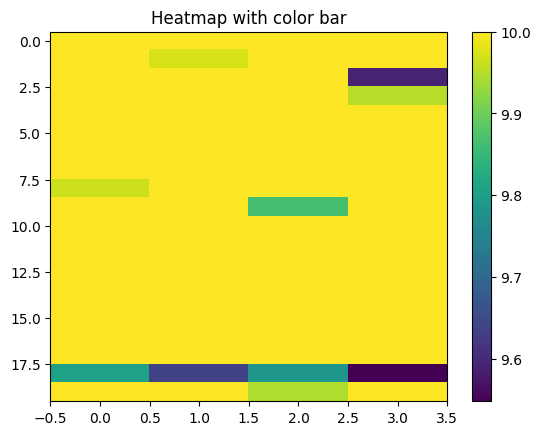

In [62]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_no_adthr = np.full((len(pg_inp), len(ng_exc_no_adthr)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_no_adthr[syns_inp_exc_no_adthr_mon.i[:,-1:], syns_inp_exc_no_adthr_mon.j[:,-1:]] = syns_inp_exc_no_adthr_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc_no_adthr, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc_no_adthr)

[[        nan  0.          0.          0.30013112]
 [10.                 nan  0.06018366  9.98261581]
 [10.          9.90720753         nan 10.        ]
 [ 9.89594534  0.          0.                 nan]]


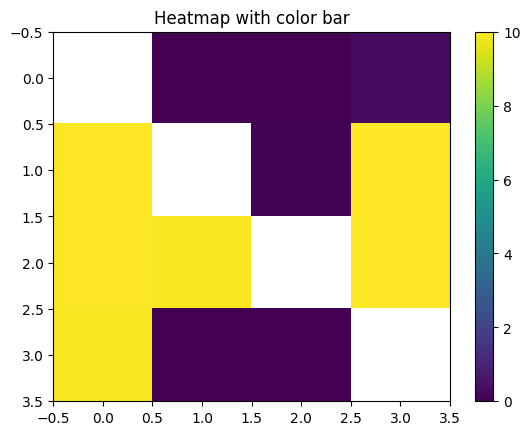

In [63]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc_no_adthr = np.full((len(ng_exc_no_adthr), len(ng_exc_no_adthr)), np.nan)
# Insert the values from the Synapses object
W_exc_exc_no_adthr[syns_exc_exc_no_adthr_mon.i[:,-1:], syns_exc_exc_no_adthr_mon.j[:,-1:]] = syns_exc_exc_no_adthr_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc_no_adthr, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_exc_exc_no_adthr)

[[10.         10.         10.         10.        ]
 [ 9.99684986  9.71568818  7.94239407  9.51921535]
 [10.          9.99836175 10.         10.        ]
 [ 8.92321298  8.57805044  9.22326437  9.51404119]
 [ 6.77357418  7.31779797  6.22472117  6.29251426]
 [ 8.07663289  6.22776808  9.0119453   7.84798172]
 [ 9.8910743   9.74162693  9.95233645  9.94043361]
 [ 8.7507407   8.76158348  7.3836977   8.36346695]
 [ 5.6513934   7.69776345  6.19906784  6.31277866]
 [ 7.85673858  6.9839048   8.05871359  8.333294  ]
 [ 8.4217401   7.17573186  7.92070503  8.00020182]
 [ 8.35295601  7.49042193  7.61588576  6.46406316]
 [ 8.88495541  7.26034482  8.54501539  8.41242372]
 [ 9.33061428  7.89057178  9.69651287  8.71226126]
 [ 5.90906381  6.61162756  7.12076534  6.63766556]
 [ 6.55838879  6.55505108  7.29676919  7.17773256]
 [ 7.35134188  9.99989807  7.21794349  6.66535085]
 [ 9.99999997 10.          9.99999997  9.99999997]
 [ 6.22312517  5.45632285  5.83228631  5.82572595]
 [ 9.78953838 10.          9.79

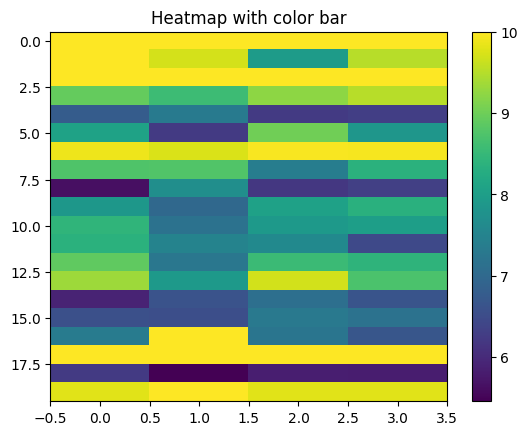

In [64]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_adthr_sm_nosie = np.full((len(pg_inp), len(ng_exc_sm_noise)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_adthr_sm_nosie[syns_inp_exc_adthr_sm_noise_mon.i[:,-1:], syns_inp_exc_adthr_sm_noise_mon.j[:,-1:]] = syns_inp_exc_adthr_sm_noise_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc_adthr_sm_nosie, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc_adthr_sm_nosie)

[[           nan 3.35754700e-37 9.83982922e+00 1.00000000e+01]
 [9.98050034e+00            nan 9.98050667e+00 1.00000000e+01]
 [1.00000000e+01 1.76362452e-01            nan 1.00000000e+01]
 [5.21528861e-01 3.35754701e-37 8.68503474e-01            nan]]


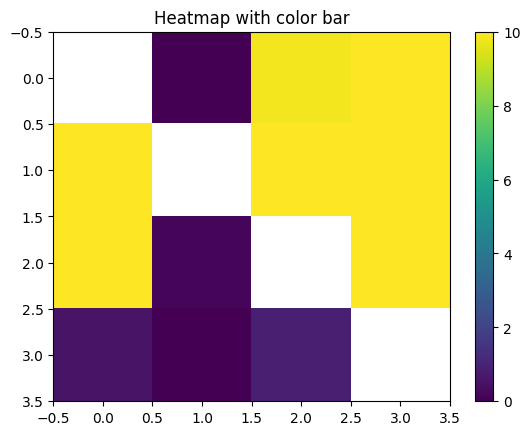

In [65]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc_adthr_sm_nosie = np.full((len(ng_exc_sm_noise), len(ng_exc_sm_noise)), np.nan)
# Insert the values from the Synapses object
W_exc_exc_adthr_sm_nosie[syns_exc_exc_adthr_time_snoise_mon.i[:,-1:], syns_exc_exc_adthr_time_snoise_mon.j[:,-1:]] = syns_exc_exc_adthr_time_snoise_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc_adthr_sm_nosie, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_exc_exc_adthr_sm_nosie)

[[2.98776461e-02 2.17050838e-12 6.65604943e-08 2.30156272e-07]
 [2.29945833e-03 2.09988210e-03 1.19036780e-02 1.69908232e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.97741876e-02 2.08512971e-07 5.99784549e-06 2.89740857e-01]
 [4.06574086e-01 1.59054521e+00 8.24066179e-02 4.96973150e+00]
 [1.77468342e-01 3.21320882e-01 1.07631027e-01 1.08842762e-01]
 [3.86266408e-01 5.47347922e-02 1.84292700e+00 4.33264889e+00]
 [1.22788184e+00 4.50691757e-01 4.90068269e-01 4.46645493e+00]
 [8.30437787e-01 3.03617877e-15 4.57534681e-10 2.77923457e+00]
 [4.74558241e+00 2.37789829e+00 3.36410635e+00 8.75450993e+00]
 [3.08021802e+00 2.47257904e-01 1.98304663e-01 6.23311597e+00]
 [2.00595737e+00 1.75574352e+00 3.36996030e+00 4.42842022e+00]
 [8.35457832e+00 8.88037300e+00 4.95566731e+00 8.27666927e+00]
 [5.14169623e+00 9.29894902e+00 1.57234990e+00 5.80445895e+00]
 [1.40238463e-02 1.21099680e-01 1.87261096e-01 4.70506223e+00]
 [9.95176551e+00 9.89238708e+00 1.00000000e+01 1.000000

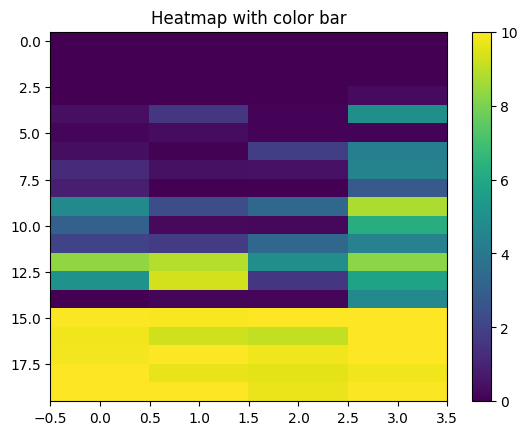

In [66]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_no_adthr_vstdp = np.full((len(pg_inp), len(ng_exc_no_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_no_adthr_vstdp[syns_inp_exc_no_adthr_vstdp_mon.i[:,-1:], syns_inp_exc_no_adthr_vstdp_mon.j[:,-1:]] = syns_inp_exc_no_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc_no_adthr_vstdp)

[[           nan 1.26137785e+00 1.14755979e+00 4.60080971e-01]
 [0.00000000e+00            nan 7.93302526e-01 1.75088983e-03]
 [0.00000000e+00 0.00000000e+00            nan 5.76745539e-02]
 [4.15487200e+00 5.85662332e+00 9.12065327e+00            nan]]


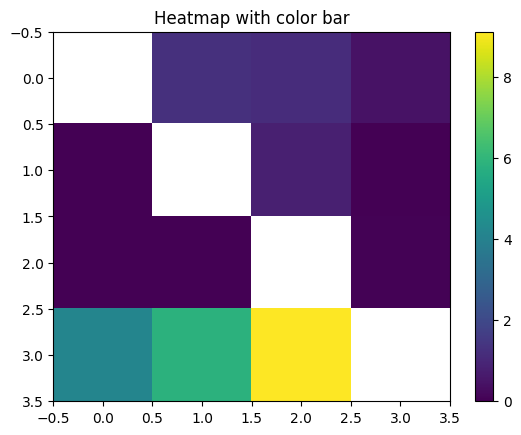

In [67]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc_no_adthr_vstdp = np.full((len(ng_exc_no_adthr_vstdp), len(ng_exc_no_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_exc_exc_no_adthr_vstdp[syns_exc_exc_no_adthr_vstdp_mon.i[:,-1:], syns_exc_exc_no_adthr_vstdp_mon.j[:,-1:]] = syns_exc_exc_no_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_exc_exc_no_adthr_vstdp)

[[9.83037813e-01 1.57450037e+00 2.45458426e+00 1.11863391e+00]
 [2.32704826e+00 3.44566826e+00 3.75736180e+00 3.12768864e+00]
 [0.00000000e+00 4.17279247e-03 1.24561940e+00 2.68946851e-01]
 [3.18452860e+00 3.93996133e+00 4.55809697e+00 3.67774644e+00]
 [2.60171177e+00 3.75014822e+00 3.20892317e+00 3.19097143e+00]
 [1.90047448e+00 3.73413704e+00 4.28003368e+00 2.99732881e+00]
 [4.41348917e+00 4.68465925e+00 4.79766384e+00 4.45506339e+00]
 [4.23592169e+00 4.89946108e+00 5.38951616e+00 4.65464607e+00]
 [3.89342718e+00 3.99371972e+00 4.42082025e+00 3.70914695e+00]
 [4.97513743e+00 5.30531369e+00 5.31498850e+00 5.11230070e+00]
 [3.91136670e+00 4.39283542e+00 4.75372586e+00 4.15995794e+00]
 [4.71942256e+00 5.57094353e+00 5.58726461e+00 5.62711406e+00]
 [3.74283685e+00 5.05269814e+00 5.19158457e+00 5.03129497e+00]
 [4.96770766e+00 4.52306247e+00 4.48827295e+00 4.25718763e+00]
 [3.65766179e+00 4.93226708e+00 5.26050669e+00 4.46981571e+00]
 [5.19890605e+00 5.57623719e+00 5.55366351e+00 5.065964

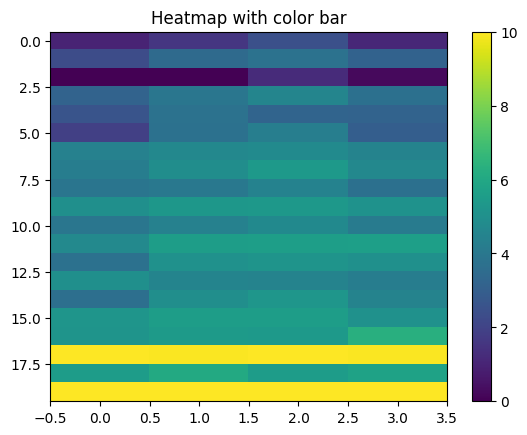

In [69]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_adthr_vstdp = np.full((len(pg_inp), len(ng_exc_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_adthr_vstdp[syns_inp_exc_adthr_vstdp_mon.i[:,-1:], syns_inp_exc_adthr_vstdp_mon.j[:,-1:]] = syns_inp_exc_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc_adthr_vstdp)

[[           nan 0.00000000e+00 2.37459810e-11 1.53979823e-01]
 [1.00000000e+01            nan 1.44737816e-01 1.00000000e+01]
 [9.99377980e+00 9.89567894e+00            nan 9.99378156e+00]
 [1.00000000e+01 0.00000000e+00 2.50086852e-11            nan]]


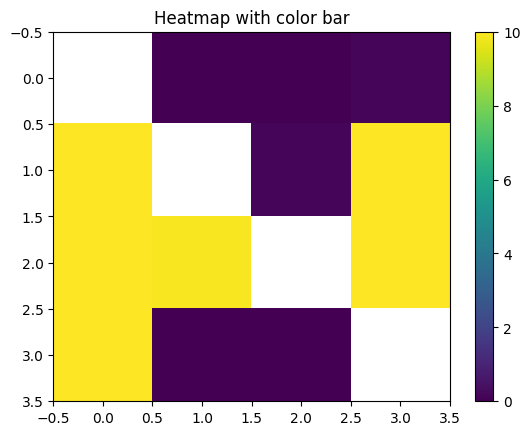

In [70]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc_adthr_vstdp = np.full((len(ng_exc_adthr_vstdp), len(ng_exc_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_exc_exc_adthr_vstdp[syns_exc_exc_adthr_vstdp_mon.i[:,-1:], syns_exc_exc_adthr_vstdp_mon.j[:,-1:]] = syns_exc_exc_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar()
print(W_exc_exc_adthr_vstdp)

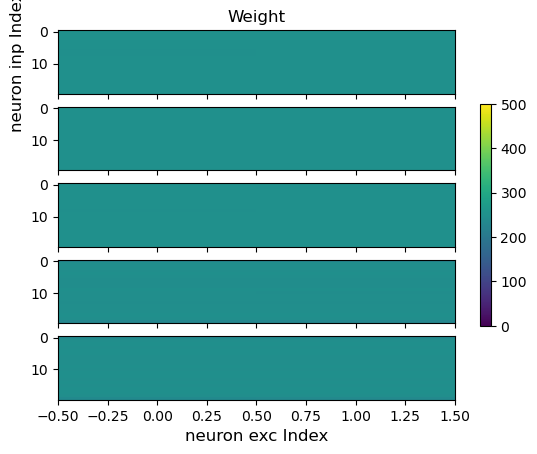

In [291]:
## Reference:
# [1] https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html

#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
#W_inp_exc = np.full((len(pg_inp), len(ng_exc)), np.nan)
# Insert the values from the Synapses object
#W_inp_exc[syns_inp_exc_mon.i[:,-1:], syns_inp_exc_mon.j[:,-1:]] = syns_inp_exc_mon.w[:, -1:]

#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
#W_inp_exc_no_adthr = np.full((len(pg_inp), len(ng_exc_no_adthr)), np.nan)
# Insert the values from the Synapses object
#W_inp_exc_no_adthr[syns_inp_exc_no_adthr_mon.i[:,-1:], syns_inp_exc_no_adthr_mon.j[:,-1:]] = syns_inp_exc_no_adthr_mon.w[:, -1:]

#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
#W_inp_exc_adthr_sm_nosie = np.full((len(pg_inp), len(ng_exc_sm_noise)), np.nan)
# Insert the values from the Synapses object
#W_inp_exc_adthr_sm_nosie[syns_inp_exc_adthr_sm_noise_mon.i[:,-1:], syns_inp_exc_adthr_sm_noise_mon.j[:,-1:]] = syns_inp_exc_adthr_sm_noise_mon.w[:, -1:]

# must set vmin, vmax, so that the colobar is shared correctly
vmin = 0
vmax = wmax
fontsize=12
fig, axsRight = subplots(5, sharex=True)
pc = axsRight[0].imshow(W_inp_exc, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[0].set_xlabel('neuron exc Index', fontsize=fontsize)
axsRight[0].set_ylabel('neuron inp Index', fontsize=fontsize)
axsRight[0].set_title('Weight', fontsize=fontsize)

pc = axsRight[1].imshow(W_inp_exc_no_adthr, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[1].set_xlabel('neuron exc Index', fontsize=fontsize)
#axsRight[1].set_ylabel('neuron inp Index', fontsize=fontsize)
#axsRight[1].set_title('Title', fontsize=fontsize)

pc = axsRight[2].imshow(W_inp_exc_adthr_sm_nosie, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[2].set_xlabel('neuron exc Index', fontsize=fontsize)


pc = axsRight[3].imshow(W_inp_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[3].set_xlabel('neuron exc Index', fontsize=fontsize)

pc = axsRight[4].imshow(W_inp_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
axsRight[4].set_xlabel('neuron exc Index', fontsize=fontsize)


colorbar(pc, shrink=0.6, ax=axsRight)
#suptitle('Weights', fontsize='x-large')
show()

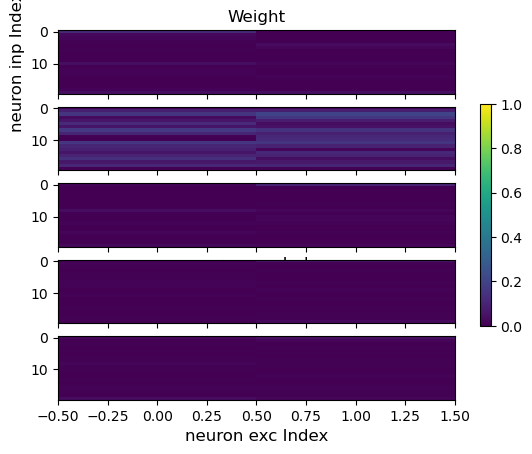

In [620]:
Diff_inp_exc = abs(W_inp_exc - prev_inp_exc)
Diff_inp_exc_no_adthr = abs(W_inp_exc_no_adthr - prev_inp_excc_no_adthr)
Diff_inp_exc_sm_nosie = abs(W_inp_exc_adthr_sm_nosie - prev_inp_exc_adthr_sm_nosie)
Diff_inp_exc_no_adthr_vstdp = abs(W_inp_exc_no_adthr_vstdp - prev_inp_exc_no_adthr_vstdp)
Diff_inp_exc_adthr_vstdp = abs(W_inp_exc_adthr_vstdp - prev_inp_exc_adthr_vstdp)

# must set vmin, vmax, so that the colobar is shared correctly
vmin =  0
vmax = 1
fontsize=12
fig, axsRight = subplots(5, sharex=True)
pc = axsRight[0].imshow(Diff_inp_exc, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[0].set_xlabel('neuron exc Index', fontsize=fontsize)
axsRight[0].set_ylabel('neuron inp Index', fontsize=fontsize)
axsRight[0].set_title('Weight', fontsize=fontsize)

pc = axsRight[1].imshow(Diff_inp_exc_no_adthr, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[1].set_xlabel('neuron exc Index', fontsize=fontsize)
#axsRight[1].set_ylabel('neuron inp Index', fontsize=fontsize)
#axsRight[1].set_title('Title', fontsize=fontsize)

pc = axsRight[2].imshow(Diff_inp_exc_sm_nosie, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
axsRight[2].set_xlabel('neuron exc Index', fontsize=fontsize)
#axsRight[2].set_ylabel('neuron inp Index', fontsize=fontsize)
#axsRight[1].set_title('Title', fontsize=fontsize)

pc = axsRight[3].imshow(Diff_inp_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)


pc = axsRight[4].imshow(Diff_inp_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
axsRight[4].set_xlabel('neuron exc Index', fontsize=fontsize)


colorbar(pc, shrink=0.6, ax=axsRight)
#suptitle('Weights', fontsize='x-large')
show()


In [621]:
prev_inp_exc = W_inp_exc
prev_inp_excc_no_adthr = W_inp_exc_no_adthr
prev_inp_exc_adthr_sm_nosie = W_inp_exc_adthr_sm_nosie
prev_inp_exc_no_adthr_vstdp = W_inp_exc_no_adthr_vstdp
prev_inp_exc_adthr_vstdp = W_inp_exc_adthr_vstdp

In [622]:
# average of total weight of all the synapses
avr_sum_w = []
avr_sum_w_no_adthr = []
avr_sum_w_adthr_sm_nosie = []
avr_sum_w_no_adthr_vstdp = []
avr_sum_w_adthr_vstdp = []

# average the weight over every 100ms, over number of total synapses
time_interval = 1e4 *ms
num_w = int(time_interval / defaultclock.dt)

#window = np.arange(100000 * ms, 200000 * ms, defaultclock.dt) / ms
time_window = 6.5e5* ms
for i in range(int(time_window/time_interval)): # range(2): # range(int(1/1e-3)):
#for i in window: # range(2): # range(int(1/1e-3)):
    avr_over_time = np.average(syns_inp_exc_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_no_adthr = np.average(syns_inp_exc_no_adthr_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_adthr_sm_nosie = np.average(syns_inp_exc_adthr_sm_noise_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_no_adthr_vstdp = np.average(syns_inp_exc_no_adthr_vstdp_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_adthr_vstdp = np.average(syns_inp_exc_adthr_vstdp_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    #print(shape(avr_over_time))
    avr_over_synap = np.average(avr_over_time, axis=0,  keepdims=True)
    avr_over_synap_no_adthr = np.average(avr_over_time_no_adthr, axis=0,  keepdims=True)
    avr_over_synap_adthr_sm_nosie = np.average(avr_over_time_adthr_sm_nosie, axis=0,  keepdims=True)
    avr_over_synap_no_adthr_vstdp = np.average(avr_over_time_no_adthr_vstdp, axis=0,  keepdims=True)
    avr_over_synap_adthr_vstdp = np.average(avr_over_time_adthr_vstdp, axis=0,  keepdims=True)
    #print(shape(avr_over_synap))
    # flattened
    avr_over_synap = np.reshape(avr_over_synap, (-1))
    avr_over_synap_no_adthr = np.reshape(avr_over_synap_no_adthr, (-1))
    avr_over_synap_adthr_sm_nosie = np.reshape(avr_over_synap_adthr_sm_nosie, (-1))
    avr_over_synap_no_adthr_vstdp = np.reshape(avr_over_synap_no_adthr_vstdp, (-1))
    avr_over_synap_adthr_vstdp = np.reshape(avr_over_synap_adthr_vstdp, (-1))
    #print(shape(avr_over_synap))
    avr_sum_w.append(avr_over_synap)
    avr_sum_w_no_adthr.append(avr_over_synap_no_adthr)
    avr_sum_w_adthr_sm_nosie.append(avr_over_synap_adthr_sm_nosie)
    avr_sum_w_no_adthr_vstdp.append(avr_over_synap_no_adthr_vstdp)
    avr_sum_w_adthr_vstdp.append(avr_over_synap_adthr_vstdp)


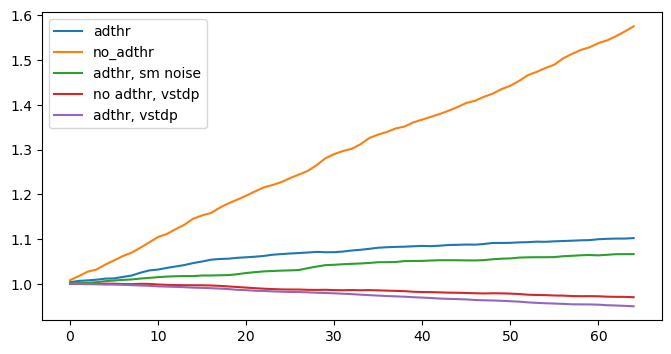

In [623]:
figure(figsize=(8, 4))
plot(np.arange(len(avr_sum_w)), avr_sum_w, label = 'adthr')
plot(np.arange(len(avr_sum_w_no_adthr)), avr_sum_w_no_adthr, label = 'no_adthr')
plot(np.arange(len(avr_sum_w_adthr_sm_nosie)), avr_sum_w_adthr_sm_nosie, label = 'adthr, sm noise')
plot(np.arange(len(avr_sum_w_no_adthr_vstdp)), avr_sum_w_no_adthr_vstdp, label = 'no adthr, vstdp')
plot(np.arange(len(avr_sum_w_adthr_vstdp)), avr_sum_w_adthr_vstdp, label = 'adthr, vstdp')
legend()
show()

## Save and Load

### Save

In [637]:
def save_npy(arr, path):
    arr = np.array(arr)
    print('%-9s %-15s => %-30s' % ('Saving', arr.shape, path))
    np.save(path, arr)

In [638]:
from pathlib import Path

In [639]:
Path.cwd()

WindowsPath('C:/Users/20245580/JupyterNotebookFiles')

In [640]:
DATA_PATH = Path('data/Exp2_DepStdp_AdapThres_2outputs/VStdp_include')

In [980]:
print(shape(syns_inp_exc_mon.w))

(40, 3240000)


In [981]:
all_w_over_trials_saved = syns_inp_exc_mon.w
print(shape(all_w_over_trials_saved))

(40, 3240000)


In [982]:
print(shape(net['exc'].theta), net['exc'].theta)

(2,) <exc.theta: array([0.01583984, 0.01605909])>


In [641]:
#athr, 
save_npy(net['inp_exc'].apre, DATA_PATH / 'apre_adthr.npy')
save_npy(net['inp_exc'].apost, DATA_PATH / 'apost_adthr.npy')
save_npy(syns_inp_exc_mon.w, DATA_PATH / 'all_w_adthr.npy')
save_npy(net['exc'].theta, DATA_PATH / 'theta_adthr.npy')
save_npy(net['exc'].ge, DATA_PATH / 'ge_adthr.npy')
save_npy(net['exc'].gi, DATA_PATH / 'gi_adthr.npy')
save_npy(net['exc'].v, DATA_PATH / 'v_adthr.npy')

#no adthr
save_npy(net['inp_exc_no_adthr'].apre, DATA_PATH / 'apre_no_adthr.npy')
save_npy(net['inp_exc_no_adthr'].apost, DATA_PATH / 'apost_no_adthr.npy')
save_npy(syns_inp_exc_no_adthr_mon.w, DATA_PATH / 'all_w_no_adthr.npy')
save_npy(net['exc_no_adthr'].theta, DATA_PATH / 'theta_no_adthr.npy')
save_npy(net['exc_no_adthr'].ge, DATA_PATH / 'ge_no_adthr.npy')
save_npy(net['exc_no_adthr'].gi, DATA_PATH / 'gi_no_adthr.npy')
save_npy(net['exc_no_adthr'].v, DATA_PATH / 'v_no_adthr.npy')

# adthr, small noise
save_npy(net['inp_exc_no_adthr_sm_nosie'].apre, DATA_PATH / 'apre_no_adthr_sm_nosie.npy')
save_npy(net['inp_exc_no_adthr_sm_nosie'].apost, DATA_PATH / 'apost_no_adthr_sm_nosie.npy')
save_npy(syns_inp_exc_adthr_sm_noise_mon.w, DATA_PATH / 'all_w_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].theta, DATA_PATH / 'theta_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].ge, DATA_PATH / 'ge_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].gi, DATA_PATH / 'gi_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].v, DATA_PATH / 'v_no_adthr_sm_nosie.npy')


# no adthr, vstdp
save_npy(net['inp_exc_no_adthr_vstdp'].x_trace_prespike, DATA_PATH / 'x_trace_no_adthr_vstdp.npy')
save_npy(syns_inp_exc_no_adthr_vstdp.w, DATA_PATH / 'all_w_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].theta, DATA_PATH / 'theta_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].ge, DATA_PATH / 'ge_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].gi, DATA_PATH / 'gi_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v, DATA_PATH / 'v_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v_lowpass1, DATA_PATH / 'v_lowpass1_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v_lowpass2, DATA_PATH / 'v_lowpass2_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v_homeo, DATA_PATH / 'v_homeo_no_adthr_vstdp.npy')


# adthr, vstdp
save_npy(net['inp_exc_adthr_vstdp'].x_trace_prespike, DATA_PATH / 'x_trace_adthr_vstdp.npy')
save_npy(syns_inp_exc_adthr_vstdp.w, DATA_PATH / 'all_w_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].theta, DATA_PATH / 'theta_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].ge, DATA_PATH / 'ge_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].gi, DATA_PATH / 'gi_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v, DATA_PATH / 'v_no_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v_lowpass1, DATA_PATH / 'v_lowpass1_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v_lowpass2, DATA_PATH / 'v_lowpass2_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v_homeo, DATA_PATH / 'v_homeo_adthr_vstdp.npy')

Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apre_adthr.npy
Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apost_adthr.npy
Saving    (40, 1320000)   => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\all_w_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\theta_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\ge_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\gi_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\v_adthr.npy
Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apre_no_adthr.npy
Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apost_no_adthr.npy
Saving    (40, 1320000)   => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\all_w_no_adthr.npy
Saving    (2,)            => data\Exp2_DepS

### Load

In [1439]:
def load_npy(path):
    arr = np.load(path)
    print('%-9s %-30s => %-15s' % ('Loading', path, arr.shape))
    return arr

In [24]:
a = 2*mV
print(a, a/mV) 

2. mV 2.0
